# Permutation Flow-Shop Scheduling Problem

This is a variant of the Flow-shop scheduling problem (FSSP) in which the sequence of jobs is the same in every machine and there are assembly operations with arbitrary machine precedences.

$$
 \begin{align}
     \text{min} \quad & C_{\text{max}} \\
     \text{s.t.} \quad & h_{i,k} + \sum_{j \in J} p_{j,i} \cdot x_{j,k} \leq h_{j,k}
         & \forall ~ (i,j) \in E; k \in K\\
     & h_{m,k} + \sum_{j \in J} p_{j,m} \cdot x_{j,k} \leq h_{m,k+1}
         & \forall ~ m \in M; k \in K \setminus \{|K|\}\\
     & \sum_{j \in J} x_{j,k} = 1
         & \forall ~ k \in K\\
     & \sum_{k \in K} x_{j,k} = 1
         & \forall ~ j \in J\\
     & h_{m,|K|} + \sum_{j \in J} p_{j,m} \cdot x_{j,|K|} \leq C_{\text{max}}
         & \forall ~ m \in M\\
     & h_{m,k} \geq 0 & \forall ~ m \in M; k \in K\\
     & x_{j,k} \in \{0, 1\} & \forall ~ j \in J; k \in K\\
 \end{align}
 $$

Where $E$ represents the set of directed edges $(i,j)$ indicating that machine $i$ must precede machine $j$ in the processing sequence.

You can compare this implementation to MILP solvers at the [end of the notebook](#bonus---milp-model).

In [1]:
import pyomo.environ as pyo

from bnbprob.pafssp import CallbackBnB, PermFlowShop, plot_gantt
from bnbprob.pafssp.instances import (
    dpm_layout_edges,
    random_dpm,
    random_parallel_semilines,
)
from bnbprob.pafssp.mip.positional import positional_model
from bnbpy import configure_logfile


In [2]:
configure_logfile("pafssp.log", mode="w")

In [24]:
instance = random_parallel_semilines(20, (10, 10), seed=42)

# instance = random_dpm(20, (3, 9), seed=12)
print(instance.edges)

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (8, 18)]


In [25]:
# Literature mini-example
# p = [
#     [10, 18, 14, 16, 22],
#     [6, 37, 18, 9, 25],
#     [5, 4, 21, 8, 19],
# ]

# instance.p = p

In [26]:
problem = PermFlowShop.from_p(instance.p, edges=instance.edges)
bnb = CallbackBnB(eval_node="in", rtol=0.0001, save_tree=False)

In [27]:
sol = bnb.solve(problem, maxiter=10_000_000)
print(sol)

Status: OPTIMAL | Cost: 1633.0 | LB: 1633.0


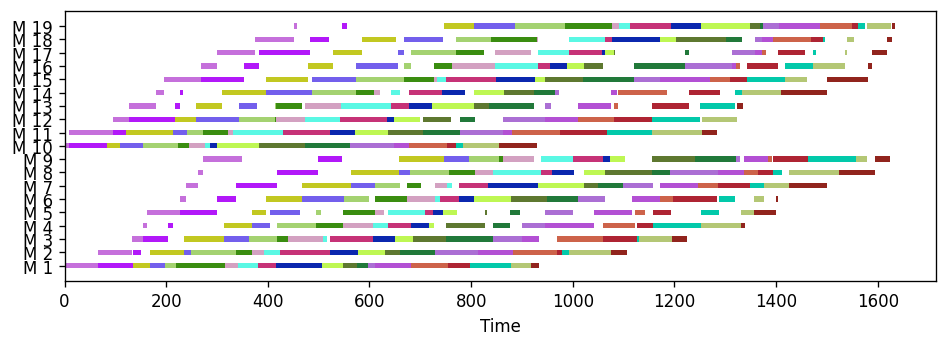

In [28]:
plot_gantt(bnb.incumbent.problem.sequence, dpi=120, seed=42, figsize=[8, 3])

In [ ]:
mip = positional_model(instance.p, edges=instance.edges)
solver = pyo.SolverFactory("appsi_highs")
solver.solve(mip, tee=True)

Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
RUN!
Coefficient ranges:
  Matrix [1e+00, 1e+02]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+00]
Presolving model
420 rows, 597 cols, 9152 nonzeros  0s
419 rows, 596 cols, 8413 nonzeros  0s

Solving MIP model with:
   419 rows
   596 cols (400 binary, 0 integer, 0 implied int., 196 continuous)
   8413 nonzeros
MIP-Timing:       0.012 - starting analytic centre calculation

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIt

In this implmentation lower bounds are computed by
the max of a single machine and
a two machine relaxations.

The bounds for single and two-machine problems are described
by Potts (1980), also implemented by Ladhari & Haouari (2005),
therein described as 'LB1' and 'LB5'.

If the attribute `constructive` is 'neh', the heuristic
of Nawaz et al. (1983) is adopted, otherwise
the strategy by Palmer (1965).


## References

Ladhari, T., & Haouari, M. (2005). A computational study of
the permutation flow shop problem based on a tight lower bound.
Computers & Operations Research, 32(7), 1831-1847.

Nawaz, M., Enscore Jr, E. E., & Ham, I. (1983).
A heuristic algorithm for the m-machine,
n-job flow-shop sequencing problem.
Omega, 11(1), 91-95.

Potts, C. N. (1980). An adaptive branching rule for the permutation
flow-shop problem. European Journal of Operational Research, 5(1), 19-25.

Palmer, D. S. (1965). Sequencing jobs through a multi-stage process
in the minimum total time—a quick method of obtaining a near optimum.
Journal of the Operational Research Society, 16(1), 101-107

## Bonus - MILP Model

This is the usual Position-based MILP model as an alternative to compare performance.


```python
import pyomo.environ as pyo

from bnbprob.pfssp.mip import positional_model

model = positional_model(p)


# HiGHS
solver = pyo.SolverFactory("appsi_highs")
solver.options["mip_heuristic_effort"] = 0.1
solver.options["time_limit"] = 120
solver.options["log_file"] = "Highs.log"
solver.solve(model, tee=True)

# Gurobi
solver = pyo.SolverFactory("gurobi", solver_io="python")
solver.options["Heuristics"] = 0.2
solver.options["Cuts"] = 2
solver.options["TimeLimit"] = 120
solver.solve(model, tee=True)
```